# Introduction à la Régression Linéaire en Machine Learning

## La Régression Linéaire

La régression linéaire cherche à ajuster une droite qui représente au mieux la relation entre une variable explicative ($x$) et une variable cible ($y$) :  
$y = ax + b$

Où :
- $a$ est la pente de la droite
- $b$ est l'ordonnée à l'origine

L'objectif est de minimiser l'erreur entre les valeurs prédites par le modèle et les valeurs réelles observées.


👉 Voici une visualisation interactive pour mieux comprendre comment la droite de régression est ajustée :  
[Visualisation dynamique](https://setosa.io/ev/ordinary-least-squares-regression/)


## Régression Linéaire avec `sklearn`

Il y a deux manières de naviguer la documentation `sklearn`:
- [User Guide](https://scikit-learn.org/stable/user_guide.html): Explication des concepts vues dans la librairie et les mathématiques qui le soulignent. Très util pour découvrir des nouveaux outils et mieux comprendre les modèles.
- [API](https://scikit-learn.org/stable/api/index.html): Comment intéragir avec la librairie à travers Python

Pour cet exemple, nous utiliserons la dataset California Housing Dataset de `sklearn`. La documentation pour ce jeu de donnée peut etre trouvé [ici](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

### Import du jeu de données

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

X, y = fetch_california_housing(as_frame = True, return_X_y= True)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Informations sur les **features** (les variables explicatives) et la **target** (la variable cible):
- `MedHouseValue`: notre target, représente le prix médian des maisons par California block group
- `MedInc`: revenu médian par California block group
- `HouseAge`: moyenne d'age des maisons par California block group
- `AveRooms`: nombre moyen de pièces par maison
- `AveBedrms`: nombre moyen de chambres à coucher par maison
- `Population`: population par California block group
- `AveOccup`: nombre moyen d'occupant par maison
- `Latitude`: latitude du California block group
- `Longitude`: longitude du California block group

Vu que nous avons la `longitude` et la `latitude` de chaque block nous pouvons voir la distribution spatiale de notre target 

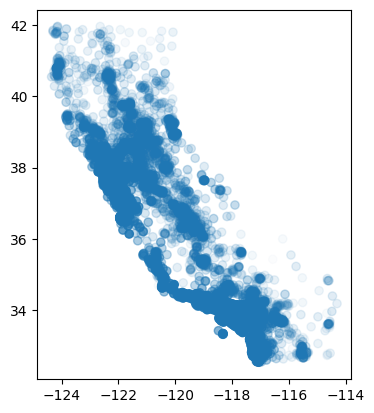

In [2]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

map_df = pd.concat([X[['Latitude', 'Longitude']],y], axis = 1)
map_geodf = geopandas.GeoDataFrame(
    map_df, geometry=geopandas.points_from_xy(map_df.Longitude, map_df.Latitude), crs="EPSG:4326"
)

# On utilise le paramètre alpha de plot pour changer l'opacité des points
# on normalise la target, les points les plus sombres ont une
# median house value plus haute
alpha_values = (y - y.min()) / (y.max() - y.min())

map_geodf.plot(alpha=alpha_values)
plt.show()

### Nettoyage de la donnée

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Il n'y a pas de valuers manquantes donc on peut continuer avec notre analyse.

### Etapes de preprocessing

Vu que nous avons seulement des données numériques nous pouvons mettre à l'échelle les variables explicatives. Il y a beaucoup d'autres étapes de feature engineering et preprocessing que nous pourrions faire mais pour l'instant nous voulons passer au modélage.

In [4]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler().set_output(transform = "pandas")
X_scaled = r_scaler.fit_transform(X)

### Entrainage du modèle `LinearRegression`

In [5]:
# Import du modèle
from sklearn.linear_model import LinearRegression

# Instantiation du modèle
model = LinearRegression()

# Entrainement du model
model.fit(X_scaled, y)

LinearRegression()

Nous avons entrainer notre algorithme d'apprentissage 🚀  
On peut l'utiliser pour obtenir des prédictions mais nous n'avons aucune idée si ce modèle a une bonne performance. Ici, l'étape d'évaluation du modèle est crucial.

## Comment faire la cross validation

#### Méthode `train_test_split` (aussi appelée Hold Out Method)

In [6]:
from sklearn.model_selection import train_test_split


# Séparer nos features et target en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3)

# Instancier le modèle
model = LinearRegression()

# Entrainement du modèle
model.fit(X_train, y_train)

# Evaluation du modèle sur le jeu de test
model.score(X_test, y_test)

0.6017954898635374

Par défaut, le score pour la méthode `model.score()` pour une tache de régression est le $R^2$, mais ce score n'est pas très représentatif.  
Nous allons utiliser la Root Mean Squared Error (RMSE) ou racine de l'erreur quadratique moyenne. Cette métrqiue représente l'écart-type des résidus et pénalise plus largement les grandes erreurs.

In [7]:
from sklearn.metrics import root_mean_squared_error

score = root_mean_squared_error(y_true = y_test, y_pred = model.predict(X_test))
score

0.7314170639322102

In [8]:
score * 100_000

73141.70639322101

La target $y$ est le prix médian des maisons dans un California block group, ce prix est en centaines de milliers de dollars (100,000 USD).  
Le RMSE de notre modèle est donc de 73,141 USD

La méthode `train_test_split` n'est pas assez robuste. Nous voulons avoir une idée de la performance générale d'un modèle qui a vu toute la donnée

La `K Fold Cross Validation`

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(LinearRegression(), X_scaled, y, cv = 5, scoring = "neg_root_mean_squared_error").mean()

-0.745906836351811

Une régression linéaire hypothétique entrainée sur le jeu de données entier aurai un RMSE égal à 0.74590 ou 74,590 USD

## Amélioration du score ?

Il y a plusieurs stratégies que nous pourrions suivre pour améliorer le score:
- porter plus d'attention aux étapes de preprocessing
- utiliser la latitude et la longitude de chaque observation pour créer de nouveau features,
- utiliser un modèle plus puissant

Grace à notre `LinearRegression` nous avons maintenant un score "baseline" à battre pendant les prochaines itération.